In [1]:
# !pip3 install snscrape

In [1]:
# import snscape.twitter as sntwitter
import pandas as pd
from datetime import datetime
import os
import re
import numpy as np
import random
# nlp
import nltk
from nltk.corpus import wordnet
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
# text representation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
#models
from sklearn.cluster import KMeans, kmeans_plusplus, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import LatentDirichletAllocation
# metrics
from sklearn.metrics import silhouette_score
# feature selection
from sklearn.pipeline import Pipeline
# download those corpus if you use the lab for the first time
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# gensim packages
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class DataScraper:
    
    def __init__(self, channels, count=700, destdir="."):
        self.channels = channels
        self.destdir = destdir
        self.count = count
        dt = str(datetime.today()).replace('-', '.')
        dt = dt.replace(":", ".")
        self.filename = f'{dt}_{"_".join(channels)}.csv'
    
    def scrap(self, channel):
        tweets_list1 = []
        
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{channel}').get_items()): #declare a username 
            if i>self.count: #number of tweets you want to scrape
                break
            tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.lang]) #declare the attributes to be returned

        # Creating a dataframe from the tweets list above 
        return pd.DataFrame(tweets_list1, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'lang'])
    
    def write(self, df):
        file = f'{self.destdir}/{self.filename}'
        print(f"writing data file {file}")
        mode="w"
        with_header = True
        if os.path.isfile(file) :
            mode = 'a'
            with_header = False
        df.to_csv(f"{self.destdir}/{self.filename}", index=False, mode = mode, header= with_header)
        pass
    
    def start(self):
        for channel in self.channels:
            print(f"scrapping data from:{channel}")
            tweets = self.scrap(channel)
            self.write(tweets)
        pass

In [34]:
ds = DataScraper(['CNN', 'FoxNews', 'BBCWorld'],800)
ds.start()

scrapping data from:CNN
writing data file ./2021.12.15 23.59.21.552562_CNN_FoxNews_BBCWorld.csv
scrapping data from:FoxNews
writing data file ./2021.12.15 23.59.21.552562_CNN_FoxNews_BBCWorld.csv
scrapping data from:BBCWorld
writing data file ./2021.12.15 23.59.21.552562_CNN_FoxNews_BBCWorld.csv


In [5]:
data = pd.read_csv("../data/2021.12.15 23.59.21.552562_CNN_FoxNews_BBCWorld.csv")
data

,Datetime,Tweet Id,Text,Username,lang
0,2021-12-15 22:44:15+00:00,1471249774733049870,The Mars Perseverance rover's latest finding s...,CNN,en
1,2021-12-15 22:30:10+00:00,1471246230210629632,The crowds are back and so are we! Who’s excit...,CNN,en
2,2021-12-15 22:12:13+00:00,1471241713700249607,The New York Police Department is searching fo...,CNN,en
3,2021-12-15 22:01:06+00:00,1471238916065964033,The CDC's vaccine advisers will meet on Thursd...,CNN,en
4,2021-12-15 21:46:44+00:00,1471235302316515333,Americans bought substantially more hard liquo...,CNN,en
...,...,...,...,...,...
2398,2021-11-28 08:59:05+00:00,1464881520439701510,Yemen: The woman saving a crumbling heritage h...,BBCWorld,en
2399,2021-11-28 08:46:56+00:00,1464878462724939778,New Zealand politician Julie Anne Genter cycle...,BBCWorld,en
2400,2021-11-28 08:46:01+00:00,1464878233606922243,The migrants returned to Iraqi camps from Bela...,BBCWorld,en
2401,2021-11-28 08:36:06+00:00,1464875736762834953,More than seven billion doses of coronavirus v...,BBCWorld,en


In [6]:
class DataPreProcessor:
    def __init__(self, data):
        self.data = data
        self.stopwords = stopwords.words('english')
    
    def cleaning(self):
        # remove hyperlinks
        self.data["Text_cleaned"] = self.data["Text"].apply(lambda x: re.sub(r"http\S+", " ", x))
        # remove hashtags
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(lambda x: re.sub(r"\#\S+", " ", x))
        # remove user tag
        self.data["Text_cleaned"] =self.data["Text_cleaned"].apply(lambda x: re.sub(r"\@\S+", " ", x))
        # remove tweet handler
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(lambda x: re.sub(r"\$\S+", " ", x))
        # remove ponctuation
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(lambda x: re.sub(r"[^A-z\t]", " ", x))
        # lowercase text
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(lambda x: x.lower())
        # tokenize text
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(lambda x: nltk.word_tokenize(x))
        # remove stop words
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(lambda x: [w for w in x if not w in self.stopwords])
        # remove stop words
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(lambda x: [w for w in x if len(w) > 2])
        # lemmatizing text
        lemmatizer = WordNetLemmatizer()
        self.data["Text_cleaned"] = self.data["Text_cleaned"].apply(
            lambda x: [lemmatizer.lemmatize(w, self.wordnet_pos(w)) for w in x])
        return self.data
    
    def wordnet_pos(self, word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {'J': wordnet.ADJ,
                    'N': wordnet.NOUN,
                    'V': wordnet.VERB,
                    'R': wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    def start(self):
        self.cleaning()
        
        return self.data
        pass

In [7]:
datapreprocessor = DataPreProcessor(data)
preprocessed_data = datapreprocessor.start()

In [8]:
train_data = list(preprocessed_data["Text_cleaned"])
train_data

[['mar',
  'perseverance',
  'rover',
  'late',
  'find',
  'suggests',
  'bedrock',
  'drive',
  'since',
  'land',
  'form',
  'magma',
  'something',
  'completely',
  'unexpected',
  'accord',
  'mission',
  'scientist'],
 ['crowd', 'back', 'excite', 'new', 'year', 'eve', 'celebration', 'start'],
 ['new',
  'york',
  'police',
  'department',
  'search',
  'man',
  'say',
  'may',
  'connect',
  'scribble',
  'swastika',
  'pillar',
  'city',
  'hall',
  'well',
  'charge',
  'bull',
  'statue',
  'near',
  'wall',
  'street'],
 ['cdc',
  'vaccine',
  'adviser',
  'meet',
  'thursday',
  'revisit',
  'benefit',
  'risk',
  'johnson',
  'amp',
  'johnson',
  'covid',
  'vaccine'],
 ['american',
  'bought',
  'substantially',
  'hard',
  'liquor',
  'wine',
  'less',
  'beer',
  'early',
  'day',
  'pandemic',
  'state',
  'resident',
  'binge',
  'accord',
  'sale',
  'data'],
 ['bell',
  'hook',
  'beloved',
  'poet',
  'author',
  'feminist',
  'professor',
  'die',
  'announce',


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(list(train_data))

# Create Corpus
texts = train_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accord', 1),
  ('bedrock', 1),
  ('completely', 1),
  ('drive', 1),
  ('find', 1),
  ('form', 1),
  ('land', 1),
  ('late', 1),
  ('magma', 1),
  ('mar', 1),
  ('mission', 1),
  ('perseverance', 1),
  ('rover', 1),
  ('scientist', 1),
  ('since', 1),
  ('something', 1),
  ('suggests', 1),
  ('unexpected', 1)]]

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=train_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.705990688997007

Coherence Score:  0.4580548116364178


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
0      0.11356  0.169844       1        1  36.648065
2     -0.22515  0.000994       2        1  32.705184
1      0.11159 -0.170838       3        1  30.646751, topic_info=         Term        Freq       Total Category  logprob  loglift
873    return  188.000000  188.000000  Default  30.0000  30.0000
5175     camp  163.000000  163.000000  Default  29.0000  29.0000
56    vaccine  172.000000  172.000000  Default  28.0000  28.0000
5800    iraqi  160.000000  160.000000  Default  27.0000  27.0000
5799  belarus  160.000000  160.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2568  migrant  119.239602  345.125589   Topic3  -4.2455   0.1199
520     first   43.771551   72.425128   Topic3  -5.2477   0.6791
384     woman   45.878058   81.531682   Topic3  -5.2006   0.6076
565     child   26.364884   33.777698   Topic3  -5.7546   0.9349
37        say   26.199293  153.869392   Topic3  -5.7609  -0.5877

[142 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2265      1  0.982925    abortion
2963      1  0.992349    activist
2963      2  0.006051    activist
2963      3  0.006051    activist
5787      2  0.997152  administer
...     ...       ...         ...
384       3  0.564198       woman
230       2  0.977801       world
5788      2  0.997152   worldwide
25        3  0.989237        year
45        1  0.960396        york

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [15]:
import os
os.environ.update({'MALLET_HOME':r'C:/Users/SuicV/Desktop/mallet-2.0.8'})

In [16]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'C:/Users/SuicV/Desktop/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)
ldamallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamallet, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.215658 -0.226345       1        1  20.088945
4      0.295290  0.211859       2        1  20.065014
0     -0.255997 -0.069603       3        1  19.985348
3     -0.169542  0.289811       4        1  19.962370
1     -0.085408 -0.205722       5        1  19.898324, topic_info=         Term        Freq       Total Category  logprob  loglift
25       year  199.000000  199.000000  Default  30.0000  30.0000
532     biden  151.000000  151.000000  Default  29.0000  29.0000
50      covid  143.000000  143.000000  Default  28.0000  28.0000
36     police  102.000000  102.000000  Default  27.0000  27.0000
114    people   96.000000   96.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
545   lawsuit   23.347121   23.347121   Topic5  -5.4443   1.6145
384     woman   95.612019   98.961503   Topic5  -4.0344   1.5801
549     texas   41.135404   42.250427   Topic5  -4.8779   1.5878
1418      sex   28.905959   30.020983   Topic5  -5.2307   1.5767
121     death   36.688333   60.134722   Topic5  -4.9923   1.1204

[315 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
492       5  0.985132           abuse
0         4  1.003757          accord
603       5  1.011902          accuse
765       1  0.990714  administration
370       5  0.899469          advert
...     ...       ...             ...
230       3  1.003927           world
1017      5  1.019398          wright
25        4  1.000738            year
45        5  1.003253            york
193       4  1.001032           young

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])

**Iterative méthode:**

In [18]:
def compute_coherence_values(id2word, corpus, texts, limit=50, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"number of topics {num_topics}")
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"coherence of model : {coherencemodel.get_coherence()}")
    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(id2word, corpus=corpus, texts=train_data, start=2, limit=12, step=1)

number of topics 2
coherence of model : 0.378242566758483
number of topics 3
coherence of model : 0.38458085767082206
number of topics 4
coherence of model : 0.3698069781733754
number of topics 5
coherence of model : 0.3874073916275359
number of topics 6
coherence of model : 0.41702063834576003
number of topics 7
coherence of model : 0.37946127928121903
number of topics 8
coherence of model : 0.402004926946238
number of topics 9
coherence of model : 0.43038619141297935
number of topics 10
coherence of model : 0.4427320478508007
number of topics 11
coherence of model : 0.433816660374827


<AxesSubplot:>

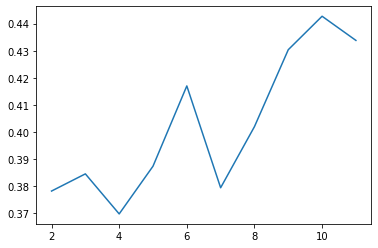

In [20]:
limit=12; start=2; step=1;
x = range(start, limit, step)
sns.lineplot(x, coherence_values)

**Model avec 10 topic**

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_list[-2], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.108902 -0.283957       1        1  10.139709
2     -0.150509  0.115637       2        1  10.101510
7      0.227610 -0.024473       3        1  10.038776
4     -0.001351  0.047585       4        1   9.988628
1      0.035285 -0.202588       5        1   9.988381
6     -0.217388  0.004872       6        1   9.986224
5      0.229897 -0.074680       7        1   9.983841
8     -0.048014  0.256565       8        1   9.977787
0      0.172777  0.167401       9        1   9.927802
9     -0.139404 -0.006364      10        1   9.867343, topic_info=             Term        Freq       Total Category  logprob  loglift
25           year  197.000000  197.000000  Default  30.0000  30.0000
532         biden  147.000000  147.000000  Default  29.0000  29.0000
50          covid  139.000000  139.000000  Default  28.0000  28.0000
36         police  102.000000  102.000000  Default  27.0000  27.0000
384         woman   98.000000   98.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
296          fire   39.585582   44.196283  Topic10  -4.2149   2.2058
437         local   18.096266   19.213823  Topic10  -4.9976   2.2560
670   vaccination   15.834233   16.945085  Topic10  -5.1312   2.2481
3553        warns   18.096266   27.036726  Topic10  -4.9976   1.9144
2192          nyc   15.834233   19.212267  Topic10  -5.1312   2.1226

[598 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2265      7  0.983520  abortion
492       7  1.020494     abuse
0         2  0.907273    accord
0         3  0.092265    accord
603       7  1.009402    accuse
...     ...       ...       ...
45        7  0.017020      york
45       10  0.987149      york
193       8  1.006117     young
369       7  0.931755   youtube
2121      5  0.983220      zoom

[643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 8, 5, 2, 7, 6, 9, 1, 10])

In [25]:
x = model_list[-2].show_topics(num_topics=11, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic, words in topics_words:
    print(f"{topic} :: {words}")


0 :: ['omicron', 'tornado', 'medium', 'variant', 'death', 'home', 'kentucky', 'change', 'health', 'end']
1 :: ['make', 'texas', 'announce', 'show', 'company', 'part', 'follow', 'space', 'ceo', 'pay']
2 :: ['house', 'trump', 'accord', 'official', 'face', 'department', 'january', 'record', 'committee', 'chief']
3 :: ['biden', 'state', 'president', 'call', 'vote', 'bill', 'republican', 'back', 'democrat', 'senate']
4 :: ['world', 'report', 'found', 'million', 'country', 'china', 'coronavirus', 'late', 'big', 'launch']
5 :: ['case', 'court', 'trial', 'child', 'smollett', 'charge', 'jussie', 'crime', 'federal', 'law']
6 :: ['year', 'cnn', 'star', 'find', 'release', 'week', 'hero', 'watch', 'officer', 'top']
7 :: ['covid', 'life', 'group', 'family', 'high', 'day', 'give', 'south', 'video', 'vaccine']
8 :: ['police', 'woman', 'time', 'school', 'kill', 'shoot', 'people', 'holiday', 'work', 'suspect']
9 :: ['christmas', 'man', 'city', 'york', 'american', 'set', 'fire', 'arrest', 'news', 'month'

**Model avec 10 topic**

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_list[-1], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.179946 -0.119491       1        1  9.232664
4     -0.194698 -0.167125       2        1  9.179977
5     -0.265758  0.111429       3        1  9.147078
2     -0.065212 -0.207344       4        1  9.136786
7      0.035826 -0.123466       5        1  9.126038
10    -0.087045  0.232157       6        1  9.093833
6      0.074069  0.267639       7        1  9.067053
9     -0.102383 -0.021967       8        1  9.012026
3      0.110397  0.009003       9        1  9.010761
8      0.238213  0.031881      10        1  9.009423
0      0.076644 -0.012716      11        1  8.984362, topic_info=         Term        Freq       Total Category  logprob  loglift
25       year  199.000000  199.000000  Default  30.0000  30.0000
50      covid  143.000000  143.000000  Default  29.0000  29.0000
532     biden  146.000000  146.000000  Default  28.0000  28.0000
36     police  101.000000  101.000000  Default  27.0000  27.0000
384     woman   99.000000   99.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
3365  boycott   13.398336   13.398336  Topic11  -5.2045   2.4097
1063   supply   12.281808   12.281808  Topic11  -5.2915   2.4097
18       back   37.961951   49.170298  Topic11  -4.1630   2.1510
79        die   23.447088   30.007151  Topic11  -4.6448   2.1630
1444      son   18.980976   22.373413  Topic11  -4.8562   2.2452

[666 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2265      4  0.982578  abortion
492       7  1.001791     abuse
0         4  1.006295    accord
603       8  1.015528    accuse
1716     11  0.970270       act
...     ...       ...       ...
25        5  1.000953      year
45        4  1.003363      york
193       9  0.997156     young
369       1  0.914625   youtube
2121      6  1.023027      zoom

[729 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 3, 8, 11, 7, 10, 4, 9, 1])